<a href="https://colab.research.google.com/github/tanvircr7/meh/blob/master/06_transfer_learning_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Installation

In [45]:
import torch
import torchvision
print(torch.__version__) # want 1.12+
print(torchvision.__version__) # want 0.13+

2.4.0+cu121
0.19.0+cu121


we have the correct versions so now we can use multi-weight API
now we'll use the 05-going-modular folder

In [46]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [47]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. GET DATA

check if data is actually in the folders

In [48]:
# !wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
import os
import zipfile


from pathlib import Path
import requests

#setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if image flder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)
  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downlaoding pizza, steak, sushi data..")
    f.write(request.content)
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)
  # remove .zip file
  os.remove(data_path/ "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists, skipping re-download


In [49]:
train_dir = image_path / "train"
test_dir = image_path / "train"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/train'))

# **2. Create Dataset and Dataloaders**

# Creating stuff but with manual transform

In [50]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

We also don't need to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

In [51]:
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

We can create these using the create_dataloaders function from the data_setup.py script we created in 05. PyTorch Going Modular Part 2.

We'll set batch_size=32 so our model sees mini-batches of 32 samples at a time.

And we can transform our images using the transform pipeline we created above by setting transform=manual_transforms.

Note: I've included this manual creation of transforms in this notebook because you may come across resources that use this style. It's also important to note that because these transforms are manually created, they're also infinitely customizable.

**So if you wanted to include data augmentation techniques in your transforms pipeline, you could.**

In [52]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78562f1ee7a0>,
 ['pizza', 'steak', 'sushi'])

# Creating stuff but with AUTO creation

Above we saw how to manually create a transform for a pretrained model.

But as of torchvision v0.13+, an automatic transform creation feature has been added.

When you setup a model from torchvision.models and select the pretrained model weights you'd like to use, for example, say we'd like to use:

In [53]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

Where,
* `EfficientNet_B0_Weights` is the model architecture weights we'd like to use (there are many different model architecture options in `torchvision.models`).
* `DEFAULT` means the *best available* weights (the best performance in ImageNet).
    * **Note:** Depending on the model architecture you choose, you may also see other options such as `IMAGENET_V1` and `IMAGENET_V2` where generally the higher version number the better. Though if you want the best available, `DEFAULT` is the easiest option. See the [`torchvision.models` documentation](https://pytorch.org/vision/main/models.html) for more.
    
Let's try it out.

In [54]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

And now to access the transforms associated with our `weights`, we can use the `transforms()` method.

**This is essentially saying "get the data transforms that were used to train the `EfficientNet_B0_Weights` on ImageNet".**

In [55]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [56]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78562f1ec790>,
 ['pizza', 'steak', 'sushi'])

The benefit of automatically creating a transform through `weights.transforms()` is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

We can use `auto_transforms` to create DataLoaders with `create_dataloaders()` just as before.

# **3. Get the pretrained model**

Understanding this **performance vs. speed vs. size** tradeoff will come with time and practice.

For me, I've found a nice balance in the `efficientnet_bX` models.

As of May 2022, [Nutrify](https://nutrify.app) (the machine learning powered app I'm working on) is powered by an `efficientnet_b0`.

[Comma.ai](https://comma.ai/) (a company that makes open source self-driving car software) [uses an `efficientnet_b2`](https://geohot.github.io/blog/jekyll/update/2021/10/29/an-architecture-for-life.html) to learn a representation of the road.

> **Note:** Even though we're using `efficientnet_bX`, it's important not to get too attached to any one architecture, as they are always changing as new research gets released. Best to experiment, experiment, experiment and see what works for your problem.

In [57]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Our `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default).

In [58]:
from torchinfo import summary
summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

In [59]:
# model.features
# model.avgpool
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

# Freezing the base model

In [60]:
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

we have to customize only classfier layer

In [61]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)
# output_shape

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [62]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# **4. Train Model**

In [63]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [64]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8435 | test_acc: 0.7734
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7236 | test_acc: 0.8867
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6054 | test_acc: 0.8828
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5494 | test_acc: 0.8984
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.5115 | test_acc: 0.9570
[INFO] Total training time: 234.533 seconds


# 5. Plot Loss **Curves**

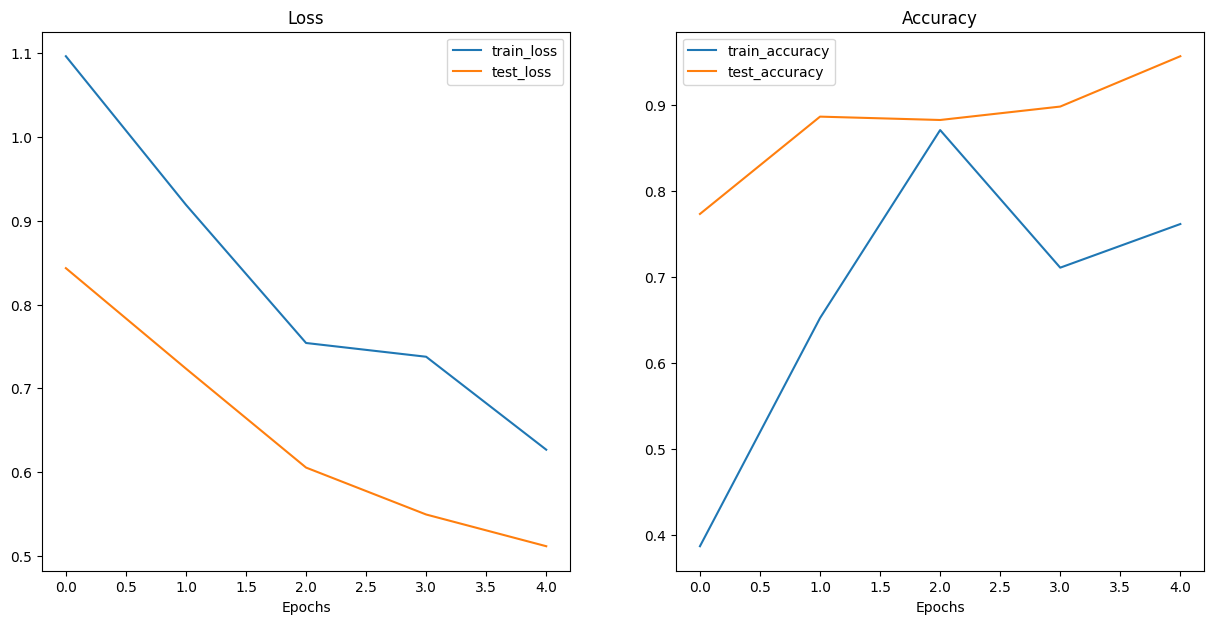

In [65]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# **6. Make Predictions**

It looks like our model performs well quantitatively but how about qualitatively?

Let's find out by making some predictions with our model on images from the test set (these aren't seen during training) and plotting them.

*Visualize, visualize, visualize!*

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the images our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make predictions on images transformed in a different way, these predictions may be off.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

> **Note:** This is a similar function to [04. PyTorch Custom Datasets section 11.3's](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function) `pred_and_plot_image()` with a few tweaked steps.

In [70]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  img = Image.open(image_path)

  if transform is not None:
    image_transform = transform

  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)


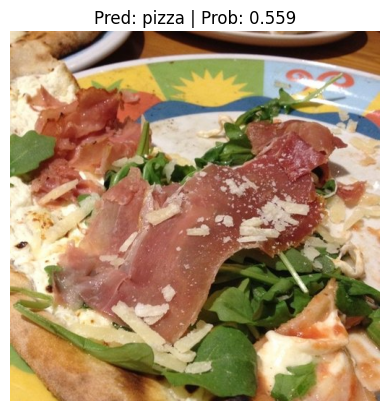

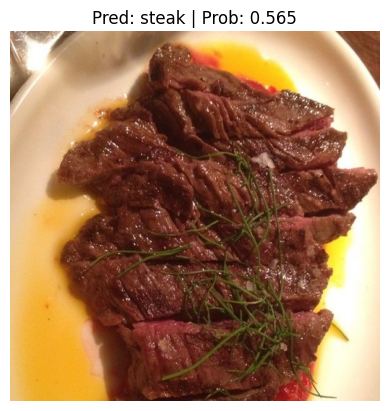

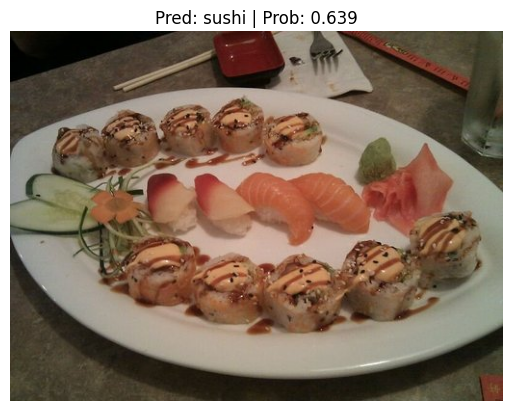

In [71]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

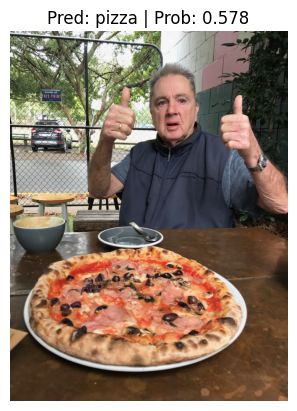

In [72]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)